In [14]:
import torch
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from dataset import CustomDataset


SR = 16000

# Load the dataset
dataset = CustomDataset(datapath='./VAD_processed/5_species/test/data.pt', type='species')
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")


In [15]:
print(len(dataset))

797


In [16]:
print(dataset[0])

(tensor([-5.7773e-06,  2.5350e-03,  2.3685e-03,  ...,  4.9263e-04,
        -1.8031e-04, -5.5399e-06]), tensor(4))


In [17]:

# Load the trained model
model_path = "/gpfs/proj1/choe_lab/tanu/Species_classification/saved_model_species/5_species/LR1e-5/Trial1_imbalanced_ep10/epoch=6.ckpt"



In [18]:
num_classes = len(dataset.label2id)
label2id=dataset.label2id
id2label=dataset.id2label

In [19]:
model = ASTForAudioClassification.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593',label2id=label2id, id2label=id2label ,num_labels=num_classes,ignore_mismatched_sizes=True)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
checkpoint = torch.load(model_path)

#pprint(model.keys())
#pprint(model['audio_spectrogram_transformer.embeddings.patch_embeddings.projection.weight'])

In [21]:
model_state_dict = checkpoint['state_dict']

In [22]:
from pytorch_lightning import LightningModule

class ASDF(LightningModule):
    def __init__(self, model):
        super(ASDF, self).__init__()
        self.model = model

In [23]:
light_model = ASDF(model)
light_model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
light_model.to(device)

def predict(audio_data):
    inputs = feature_extractor(audio_data, sampling_rate=SR, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_ids = torch.argmax(logits, dim=-1).item()
        # predicted_label = model.config.id2label[predicted_class_ids]

    return predicted_class_ids

# Test the model on a sample from the dataset
sample_idx = 0
waveform, label_id = dataset[sample_idx]
true_label = dataset.id2label[label_id.item()]

predicted_label = predict(waveform)

print(f"True label: {true_label}")
print(f"Predicted label: {predicted_label}")

In [10]:
print(dataset.id2label)
label_list = []
for k,v in dataset.id2label.items():
    label_list.append(v)
print(label_list)

{0: 'armatus', 1: 'firmus', 2: 'integer', 3: 'lightfooti', 4: 'lineaticeps'}
['armatus', 'firmus', 'integer', 'lightfooti', 'lineaticeps']


In [11]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np

In [12]:
x_data = list()
y_data = list()

for i in range(len(dataset)):
    x_data.append(dataset[i][0].numpy())
    y_data.append(dataset[i][1].numpy())

x_test = np.array(x_data)
print(x_test.shape)
y_test = np.array(y_data)
print(y_test.shape)

(797, 160000)
(797,)


In [16]:
count = {}
for i in range(len(dataset)):
    if y_test[i] not in count:
        count[y_test[i]] = 1
    else:
        count[y_test[i]] += 1
print(count)

    

{4: 109, 1: 121, 2: 119, 3: 290, 0: 158}


In [17]:
y_pred = list()
for i in tqdm(range(len(dataset))):
    waveform, label_id = dataset[i]
    y_pred_i = predict(waveform)
    y_pred.append(y_pred_i)

100%|█████████████████████████████████████████| 797/797 [00:32<00:00, 24.47it/s]


In [18]:
print(len(y_pred))

797


In [19]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [21]:

conf_matrix

array([[123,   0,  11,  24,   0],
       [  0, 121,   0,   0,   0],
       [  7,   0, 111,   1,   0],
       [  0,   0,   0, 290,   0],
       [  0,   0,   1,   0, 108]])

In [ ]:
#{0: 'armatus', 1: 'firmus', 2: 'integer', 3: 'lightfooti', 4: 'lineaticeps'}
#{4: 109, 1: 121, 2: 119, 3: 290, 0: 158}

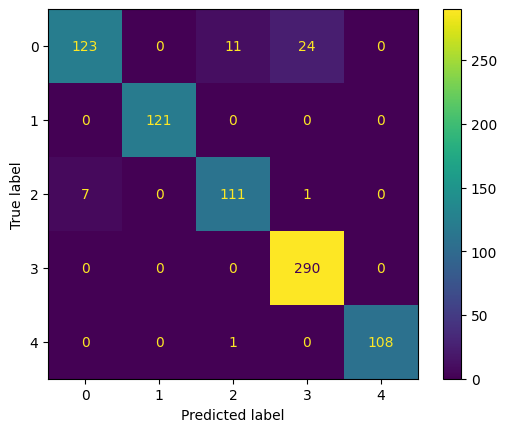

In [22]:
#imbalanced with band pass, epoch=6, acc = 95.49 ( epoch starts from 0)
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

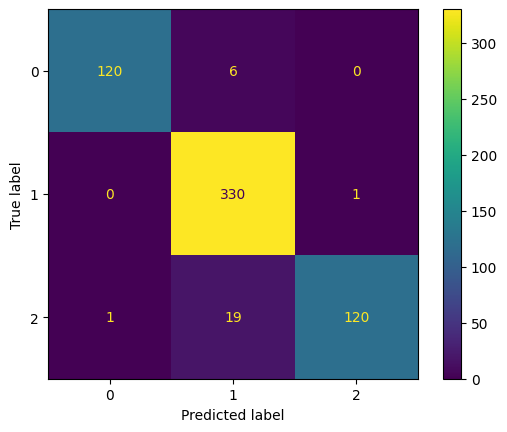

In [23]:
#imbalanced with band pass, epoch=2, acc = 94.98 ( epoch starts from 0)
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

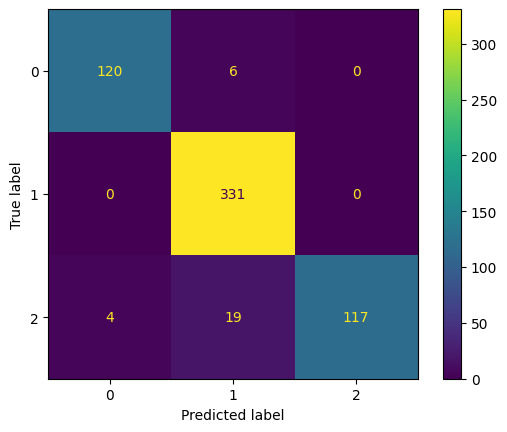

In [20]:
#imbalanced with band pass, epoch=5, acc = 94.65 ( epoch starts from 0)
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

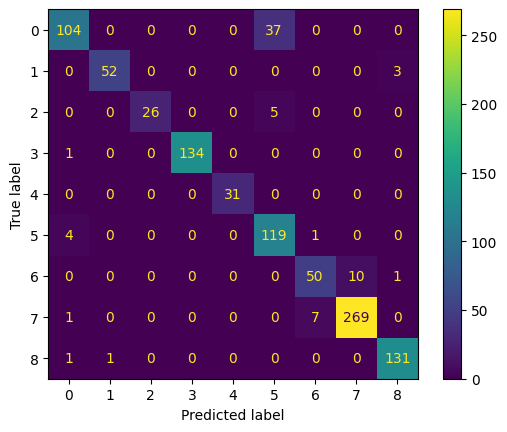

In [19]:
#imbalanced without band pass, epoch=6, acc = 92.5 ( epoch starts from 0)
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

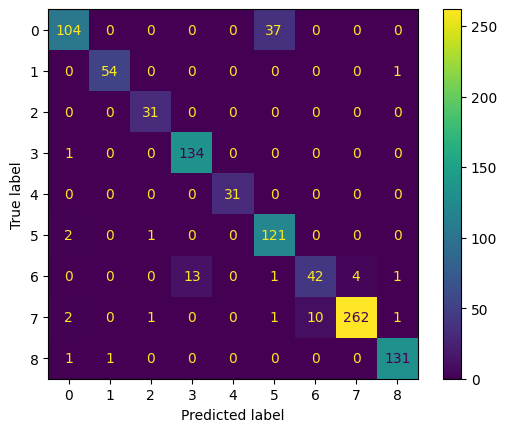

In [18]:
#balanced with band pass-600, epoch=4, acc = 92.3 ( epoch starts from 0)
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

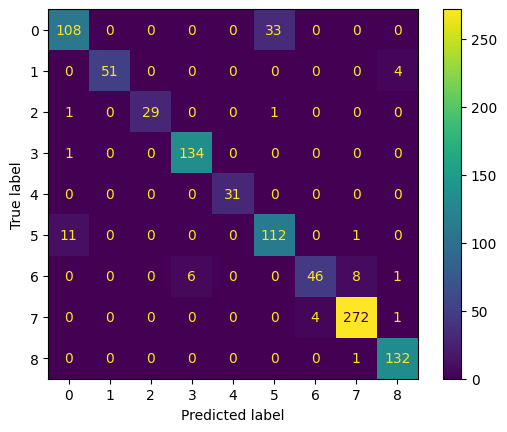

In [26]:
#imbalanced with band pass, epoch=4, acc = 92.7 ( epoch starts from 0)
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

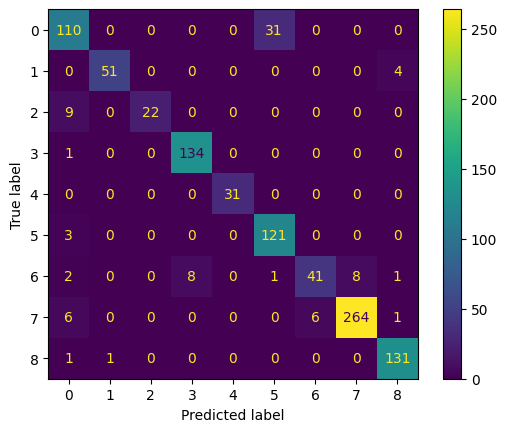

In [44]:
#balanced with band pass- 600 each, epoch=2, loss = 28%
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

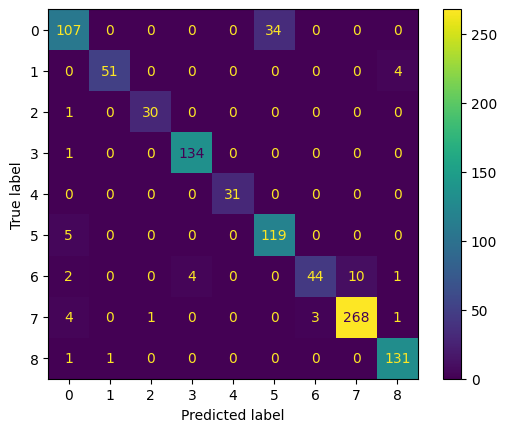

In [26]:
#balanced with band pass- 600 each, epoch=6, acc = 92.7
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

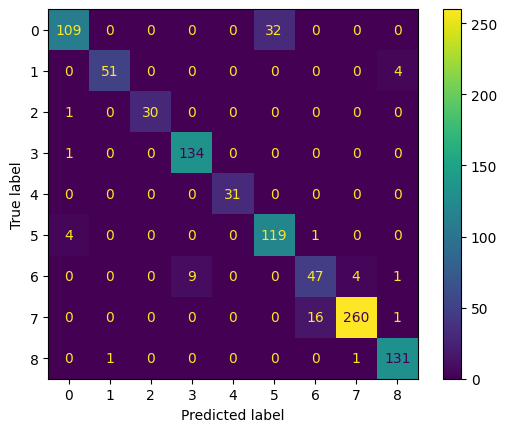

In [18]:
#balanced with band pass
metrics.ConfusionMatrixDisplay(conf_matrix).plot()

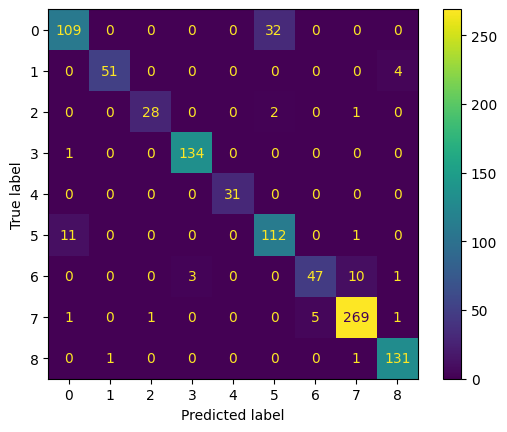

In [18]:
metrics.ConfusionMatrixDisplay(conf_matrix).plot()